In [128]:
import torch
import torch.nn as nn
import math

In [2]:
GPT_CONFIG_124M = {
"vocab_size": 50257,     # Vocabulary size
"context_length": 256,  # Context length
"emb_dim": 768,          # Embedding dimension
"n_heads": 12,           # Number of attnention heads
"n_layers": 12,          # Number of layers
"drop_rate": 0.1,        # Dropout rate
"qkv_bias": False        # Query-Key-Value bias
}

In [3]:
 class LayerNorm(nn.Module):          
    def __init__(self, emb_dim):   
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
                                  
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)

In [6]:
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [7]:
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())

In [8]:
out=layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
        (x + 0.044715 * torch.pow(x, 3))
        ))


In [137]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [139]:
ffn = FeedForward(GPT_CONFIG_124M)
total_params = sum(p.numel() for p in ffn.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 4,722,432


In [125]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
        context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads   
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)   
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length, context_length), diagonal=1))
            
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)        
        queries = self.W_query(x)   
        values = self.W_value(x) 
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)      
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)                                                                   
        keys = keys.transpose(1, 2)         
        queries = queries.transpose(1, 2)   
        values = values.transpose(1, 2)     
        attn_scores = queries @ keys.transpose(2, 3)  
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]   
        attn_scores.masked_fill_(mask_bool, -torch.inf)    
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        print("Attn weights shape ", attn_weights.shape)
        print("Values weights shape ", values.shape)
        context_vec = (attn_weights @ values).transpose(1, 2)  
        print("Context shape ", context_vec.shape)
        context_vec = context_vec.contiguous().view(
        b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)   
        return context_vec

In [130]:
total_params = sum(p.numel() for p in block.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 7,085,568


In [126]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [129]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                  
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [140]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_block = nn.Sequential(
            * [TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [141]:
tok_emb = nn.Embedding(50257, 768)
x = tok_emb(batch)
print("batch shape ",batch.shape)
print("x shape ", x.shape)

batch shape  torch.Size([2, 4])
x shape  torch.Size([2, 4, 768])


In [142]:
torch.arange(4, device = x.dev

SyntaxError: unexpected EOF while parsing (3290880344.py, line 1)

In [143]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4, 4])
Values weights shape  torch.Size([2, 12, 4, 64])
Context shape  torch.Size([2, 4, 12, 64])
Attn weights shape  torch.Size([2, 12, 4,

In [145]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [19]:
 print("Token embedding layer shape:", model.tok_emb.weight.shape)
 print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [20]:
 total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
 )
 print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
 )

Number of trainable parameters considering weight tying: 123,822,336


In [21]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,   
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,      
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]   
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx,idx_next), dim=1)
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)   
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)               
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
    )
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [22]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
               [40,    1107, 588]]) 

In [23]:
 targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                [1107, 588, 11311]]) 

In [24]:
with torch.no_grad():
    logits = model(inputs)
    print(logits.shape)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])
torch.Size([2, 3, 50257])


In [25]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids.shape)
print(token_ids)

torch.Size([2, 3, 1])
tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [26]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")

Targets batch 1:  effort moves you


In [27]:
print(targets.shape)
print(targets[0].shape)
print(token_ids[0].shape)
print(token_ids[0].flatten().shape)

torch.Size([2, 3])
torch.Size([3])
torch.Size([3, 1])
torch.Size([3])


In [28]:
print(f"Outputs batch 1:" f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Outputs batch 1: Armed heNetflix


In [29]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])


In [30]:
 print("Logits shape:", logits.shape)
 print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [31]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [32]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [33]:
file_path = "sample-text.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [34]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


In [35]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):    
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):   
        return len(self.input_ids)
    def __getitem__(self, idx):        
        return self.input_ids[idx], self.target_ids[idx]

In [37]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
             stride=128, shuffle=True, drop_last=True,
             num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                        
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)  
    dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last,    
    num_workers=num_workers    
    )
    return dataloader

In [38]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
    )
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
    )

In [39]:
print("Train loader:")
print(len(train_loader))
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
9
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [40]:
print(train_loader)

In [41]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)        
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
         num_batches = len(data_loader)    
    else:
         num_batches = min(num_batches, len(data_loader))  
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [43]:
device = torch.device("cuda")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  10.987583266364204
Validation loss:  10.98110580444336


In [44]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
        generate_and_print_sample(model,tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen
                
                
                       

In [45]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() 
    with torch.no_grad():                             
        train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [46]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [105]:
torch.manual_seed(123)
#model = GPTModel(GPT_CONFIG_124M)
gpt.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000) : Train loss 3.743, Val loss 3.560
Ep 1 (Step 000005) : Train loss 3.819, Val loss 3.560
Every effort moves you forward.  The first step is to understand the importance of your work.  The second step is to understand the importance of your work.  The third step is to understand the importance of your work.  The fourth step is
Ep 2 (Step 000010) : Train loss 3.762, Val loss 3.560
Ep 2 (Step 000015) : Train loss 3.632, Val loss 3.560
Every effort moves you forward.  The first step is to understand the importance of your work.  The second step is to understand the importance of your work.  The third step is to understand the importance of your work.  The fourth step is
Ep 3 (Step 000020) : Train loss 3.711, Val loss 3.560
Ep 3 (Step 000025) : Train loss 3.729, Val loss 3.560
Every effort moves you forward.  The first step is to understand the importance of your work.  The second step is to understand the importance of your work.  The third step is to understand the impo

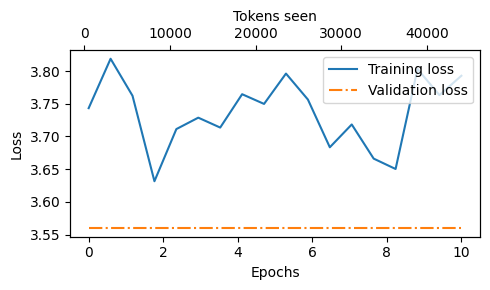

In [106]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                  
    ax2.plot(tokens_seen, train_losses, alpha=0)    
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [68]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=25,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [69]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits/temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [71]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen. It was not it was such not to see her


In [73]:
torch.save({
    "model_state_dict": model.state_dict(), 
    "optimizer_state_dict": optimizer.state_dict(),
},
           "model_and_optimizer.pth"
    )

In [74]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7f990916f070>)

In [75]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)

2025-02-15 17:49:36.072625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-15 17:49:36.858800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
checkpoint: 100%|████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 117kiB/s]
encoder.json: 100%|████████████████████████████████████████████████████| 1.04M/1.04M [00:01<00:00, 652kiB/s]
hparams.json: 100%|██████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 117kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████████████████████████████████| 498M/498M [05:46<00:00, 1.44MiB/s]
model.ckpt.index: 100%|███████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 7.42MiB/s]
model.ckpt.meta: 10

In [76]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [77]:
 print(params["wte"])
 print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [78]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [79]:
 model_name = "gpt2-small (124M)"
 NEW_CONFIG = GPT_CONFIG_124M.copy()
 NEW_CONFIG.update(model_configs[model_name])

In [80]:
 NEW_CONFIG.update({"context_length": 1024})


In [81]:
 NEW_CONFIG.update({"qkv_bias": True})


In [82]:
 gpt = GPTModel(NEW_CONFIG)
 gpt.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=

In [86]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right:{right.shape}"
         )
    return torch.nn.Parameter(torch.tensor(right))

In [100]:
import numpy as np

def load_weights_into_gpt(gpt, params):          
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):    
        q_w, k_w, v_w = np.split(                           
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_block[b].attn.W_query.weight = assign(
        gpt.trf_block[b].attn.W_query.weight, q_w.T)
        gpt.trf_block[b].attn.W_key.weight = assign(
        gpt.trf_block[b].attn.W_key.weight, k_w.T)
        gpt.trf_block[b].attn.W_value.weight = assign(
        gpt.trf_block[b].attn.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_block[b].attn.W_query.bias = assign(
        gpt.trf_block[b].attn.W_query.bias, q_b)
        gpt.trf_block[b].attn.W_key.bias = assign(
        gpt.trf_block[b].attn.W_key.bias, k_b)
        gpt.trf_block[b].attn.W_value.bias = assign(
        gpt.trf_block[b].attn.W_value.bias, v_b)
        gpt.trf_block[b].attn.out_proj.weight = assign(
        gpt.trf_block[b].attn.out_proj.weight, 
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_block[b].attn.out_proj.bias = assign(
        gpt.trf_block[b].attn.out_proj.bias, 
        params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.trf_block[b].ff.layers[0].weight = assign(
        gpt.trf_block[b].ff.layers[0].weight, 
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_block[b].ff.layers[0].bias = assign(
        gpt.trf_block[b].ff.layers[0].bias, 
        params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_block[b].ff.layers[2].weight = assign(
        gpt.trf_block[b].ff.layers[2].weight, 
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_block[b].ff.layers[2].bias = assign(
        gpt.trf_block[b].ff.layers[2].bias, 
        params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.trf_block[b].norm1.scale = assign(
        gpt.trf_block[b].norm1.scale, 
        params["blocks"][b]["ln_1"]["g"])
        gpt.trf_block[b].norm1.shift = assign(
        gpt.trf_block[b].norm1.shift, 
        params["blocks"][b]["ln_1"]["b"])
        gpt.trf_block[b].norm2.scale = assign(
        gpt.trf_block[b].norm2.scale, 
        params["blocks"][b]["ln_2"]["g"])
        gpt.trf_block[b].norm2.shift = assign(
        gpt.trf_block[b].norm2.shift, 
        params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) 

In [101]:
load_weights_into_gpt(gpt, params)
gpt.to(device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=

In [104]:
torch.manual_seed(123)
token_ids = generate(
model=gpt,
idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
max_new_tokens=25,
context_size=NEW_CONFIG["context_length"],
top_k=50,
temperature=3
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far the road can travel because I was told that with 100% recovery between breaths you'll lose as you move upwards.
